# Variational Auto Encoder with MNIST (or Fashion MNIST)

* `Auto-Encoding Variational Bayes` [arXiv:1312.6114](https://arxiv.org/abs/1312.6114)
  * Diederik P. Kingma and Max Welling

* This code is available to tensorflow version 2.0
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) [`tf.losses`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses)
* This code refers to [TensorFlow official tutorial vae code](https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/generative_examples/cvae.ipynb).

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

sys.path.append(os.path.dirname(os.path.abspath('.')))
from utils.image_utils import *
from utils.ops import *

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages

## Setting hyperparameters

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'vae'
train_dir = os.path.join('train', model_name, 'exp1')

max_epochs = 100
save_model_epochs = 5
print_steps = 100
save_images_epochs = 2
batch_size = 128
learning_rate = 1e-4
num_examples_to_generate = 16
latent_dim = 50

## Load the MNIST dataset

In [3]:
# Load training and eval data from tf.keras
(train_images, train_labels), (test_images, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(-1, MNIST_SIZE, MNIST_SIZE, 1).astype('float32')
train_images = train_images / 255.

test_images = test_images.reshape(-1, MNIST_SIZE, MNIST_SIZE, 1).astype('float32')
test_images = test_images / 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

## Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [4]:
#tf.random.set_seed(219)

# for train
N = len(train_images)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset = test_dataset.shuffle(buffer_size=N)
test_dataset = test_dataset.batch(batch_size=num_examples_to_generate)
print(test_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>
<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


## Create the AutoEncoder models

In [5]:
class Encoder(tf.keras.Model):
  def __init__(self, latent_dim=latent_dim):
    super(Encoder, self).__init__()
    self.conv1 = Conv(32, 3, 2, padding='valid', apply_batchnorm=False)
    self.conv2 = Conv(64, 3, 2, padding='valid', apply_batchnorm=False)
    self.flatten = layers.Flatten()
    self.fc = layers.Dense(units=latent_dim * 2)
    
  def call(self, inputs):
    """Run the model."""
    x = self.conv1(inputs)
    x = self.conv2(x)
    x = self.flatten(x)
    x = self.fc(x)
    
    return x

In [6]:
class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc = layers.Dense(units=7*7*32, activation='relu')
    self.reshape = layers.Reshape(target_shape=(7, 7, 32))
    self.conv1 = ConvTranspose(64, 3, 2, apply_batchnorm=False)
    self.conv2 = ConvTranspose(32, 3, 2, apply_batchnorm=False)
    self.conv3 = ConvTranspose(1, 3, 1, activation='none', apply_batchnorm=False)    
    
  def call(self, inputs):
    """Run the model."""
    x = self.fc(inputs)
    x = self.reshape(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    
    return x

In [7]:
class VariationalAutoEncoder(tf.keras.Model):
  """Build a Variational Auto Encoder
  """
  def __init__(self, latent_dim=latent_dim):
    super(VariationalAutoEncoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = Encoder(self.latent_dim)
    self.decoder = Decoder()
    
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar
  
  def reparameterize(self, mean, logvar):
    epsilon = tf.random.normal(shape=mean.shape)
    return mean + tf.exp(logvar * .5) * epsilon
  
  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.math.sigmoid(logits)
      return probs
    return logits

  def sample(self, num_examples_to_generate=num_examples_to_generate, epsilon=None):
    if epsilon is None:
      epsilon = tf.random.normal(shape=(num_examples_to_generate, self.latent_dim))
    return self.decode(epsilon, apply_sigmoid=True)

In [8]:
vae = VariationalAutoEncoder()

## Define the loss functions and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

**Normal distribution**

$$ \mathcal{N}(\mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^{2}}} \exp \left( {-\frac{(x-\mu)^{2}}{2\sigma^{2}}} \right) $$

**Log normal distribution**

$$ \log \mathcal{N}(\mu, \sigma) = -\frac{1}{2} \log(2 \pi \sigma^{2}) + \left[ -\frac{(x-\mu)^{2}}{2\sigma^{2}} \right] $$

$$ = -\frac{1}{2} \left[ \log(2 \pi) + \log(\sigma^{2}) + \frac{(x-\mu)^{2}}{\sigma^{2}} \right] $$

$$ = -\frac{1}{2} \left[ \log(2 \pi) + \log(\sigma^{2}) + (x-\mu)^{2} \exp(\log(-\sigma^{2})) \right] $$

In [9]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return -.5 * tf.reduce_sum((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi, axis=raxis)

In [10]:
def vae_loss(inputs, logits, z, z_mean, z_logvar):
  """Calculate the VAE loss
  reconstruction loss + KL divergence loss
  for each dataset in minibatch.
  Args:
    inputs (4-rank T): input images (for target labels)
    logits (4-rank T): logits of reconstructed images from P(X|z) for reconstruction loss
    z_mean (1-rank T): Multi variate normal distribution parameters
    z_logvar (1-rank T): Multi variate normal distribution parameters
  Returns:
    loss (0-rank T): reconstruction loss + KL divergence loss
  """
  # reconstruction loss, $$\log p(x| z)$$
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=inputs)
  reconstructios_loss = -tf.reduce_sum(cross_ent, axis=[1, 2, 3]) # logpx_z

  # KL Divergence D_KL( Q(z|X) || P(z|X) ),  $$\log p(z) - \log q(z|x)$$
  #KL_loss = 0.5 * tf.reduce_sum(
  #                    tf.exp(z_logvar) + z_mean**2 - 1. - z_logvar, 1)
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, z_mean, z_logvar)
  KL_loss = logpz - logqz_x
  return -tf.reduce_mean(reconstructios_loss + KL_loss)

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate)

## Checkpoints (Object-based saving)

In [12]:
checkpoint_dir = train_dir
if not tf.io.gfile.exists(checkpoint_dir):
  tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, vae=vae)

## Training

In [13]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
const_random_vector_for_saving = tf.random.normal([num_examples_to_generate, latent_dim])

### Define training one step function

In [14]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  with tf.GradientTape() as tape: 
    mean, logvar = vae.encode(images)
    z = vae.reparameterize(mean, logvar)
    x_logits = vae.decode(z)

    loss = vae_loss(images, x_logits, z, mean, logvar)

  gradients = tape.gradient(loss, vae.trainable_variables)
  optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
  
  return loss

### Train full steps

Epochs: 7.46 global_step: 3500 loss: 103.677 (21466.25 examples/sec; 0.006 sec/batch)


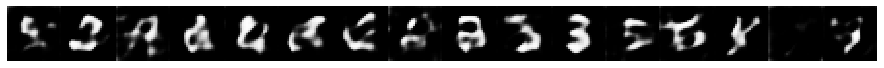

In [ ]:
print('Start Training.')
num_batches_per_epoch = int(N / batch_size)
global_step = tf.Variable(0, trainable=False)

for epoch in range(max_epochs):
  
  for step, images in enumerate(train_dataset):
    start_time = time.time()
    
    with tf.GradientTape() as tape:
      loss = train_step(images)
      global_step.assign_add(1)
    
    if global_step.numpy() % print_steps == 0:
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      display.clear_output(wait=True)
      print("Epochs: {:.2f} global_step: {} loss: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), loss, examples_per_sec, duration))
      sample_images = vae.sample(num_examples_to_generate)
      
      print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate)

  if (epoch + 1) % save_images_epochs == 0:
    display.clear_output(wait=True)
    print("This images are saved at {} epoch".format(epoch+1))
    sample_images = vae.sample(num_examples_to_generate, const_random_vector_for_saving)
    print(sample_images.shape)
    print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate,
                                is_square=True, is_save=True, epoch=epoch+1,
                                checkpoint_dir=checkpoint_dir)

  # saving (checkpoint) the model every save_epochs
  if (epoch + 1) % save_model_epochs == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)
    
print('Training Done.')

In [ ]:
# generating after the final epoch
display.clear_output(wait=True)
sample_images = vae.sample(num_examples_to_generate, const_random_vector_for_saving)
print_or_save_sample_images(sample_images.numpy(), num_examples_to_generate,
                                is_square=True, is_save=True, epoch=epoch+1,
                                checkpoint_dir=checkpoint_dir)

## Restore the latest checkpoint

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Display an image using the epoch number

In [ ]:
display_image(max_epochs, checkpoint_dir=checkpoint_dir)

## Generate a GIF of all the saved images.

In [ ]:
filename = model_name + '_' + dataset_name + '.gif'
generate_gif(filename, checkpoint_dir)

In [ ]:
display.Image(filename=filename + '.png')